In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def remove_outliers(df_in, df_out):
    mean, std = df_in.mean(), df_in.std()
    lower, upper = mean - 3 * std, mean + 3 * std  # type pd.Series
    out1 = df_in.index[(df_in < lower).any(axis=1)]
    out2 = df_in.index[(df_in > upper).any(axis=1)]
    idxs = df_in.index.drop(out1.union(out2))
    df_in = df_in.loc[idxs].copy().reset_index(drop=True)
    df_out = df_out.loc[idxs].copy().reset_index(drop=True)
    return df_in, df_out

def normalize_z(dfin):
    df_new = (dfin - dfin.mean(axis=0)) / dfin.std(axis=0)
    return df_new

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names].copy()
    df_target = df[target_names].copy()
    return df_feature, df_target

def prepare_feature(df_feature):
    m = df_feature.shape[0]
    Xtmp = df_feature.to_numpy().reshape(m, len(df_feature.columns))
    X = np.concatenate((np.ones((m,1)), Xtmp), axis=1) # m * (n+1)
    return X

def prepare_target(df_target):
    m = df_target.shape[0]
    return df_target.to_numpy().reshape(m, 1)

def predict(df_feature, beta):
    df_feature_norm = normalize_z(df_feature)
    features = prepare_feature(df_feature_norm)
    yhat = calc_linear(features, beta)
    return yhat

def calc_linear(X, beta):
    return np.matmul(X, beta)

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    total = df_feature.shape[0]
    n = int(test_size * total)
    
    np.random.seed(random_state)
    n_idxs = np.random.choice(total, n, replace=False)
    m_idxs = np.array([i for i in range(total) if i not in n_idxs])
    
    df_feature_train, df_target_train = df_feature.loc[m_idxs], df_target.loc[m_idxs]
    df_feature_test, df_target_test = df_feature.loc[n_idxs], df_target.loc[n_idxs]
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test


In [4]:
# Read the CSV file
df = pd.read_csv("..\..\datasets\Processed\All_DF_Processed.csv")
df.head()

,ISO3_Code,Country_Name,M49_Code,Life_Expectancy_2016,Life_Expectancy_2017,Life_Expectancy_2018,Life_Expectancy_2019,Life_Expectancy_2020,Mean_Years_Of_Schooling_2016,Mean_Years_Of_Schooling_2017,...,Access_To_Electricity_2016,Access_To_Electricity_2017,Access_To_Electricity_2018,Access_To_Electricity_2019,Access_To_Electricity_2020,Prevalence_of_undernourishment_2016,Prevalence_of_undernourishment_2017,Prevalence_of_undernourishment_2018,Prevalence_of_undernourishment_2019,Prevalence_of_undernourishment_2020
0,AFG,Afghanistan,4.0,63.1361,63.0160,63.0810,63.5645,62.5751,2.463660,2.561425,...,97.699997,97.699997,96.616135,97.699997,97.699997,22.2,23.0,24.0,26.9,29.8
1,AGO,Angola,24.0,61.0923,61.6798,62.1438,62.4484,62.2612,5.417391,5.417391,...,41.813129,43.013260,45.290001,45.642799,46.890610,15.4,15.4,15.7,17.9,20.8
2,ALB,Albania,8.0,78.8602,79.0473,79.1838,79.2825,76.9893,10.727528,10.910692,...,99.889999,99.889999,100.000000,100.000000,100.000000,4.7,4.7,4.6,4.3,3.9
3,ARE,United Arab Emirates,784.0,79.3347,79.5036,79.6274,79.7262,78.9457,10.842620,12.055400,...,100.000000,100.000000,100.000000,100.000000,100.000000,6.3,6.4,6.2,6.0,5.6
4,ARG,Argentina,32.0,76.3077,76.8330,76.9994,77.2845,75.8921,10.928190,11.016445,...,99.849579,100.000000,99.989578,100.000000,100.000000,2.6,3.1,3.4,3.5,3.7


## I. Preliminary model

### Preprocessing
0. (null values already replaced with mean in loaded dataset)
1. Remove outliers (< or > 3*std)
2. Normalize features

In [5]:
# Extract the features and the targets
tmp = df.columns[df.columns.str.contains("_2020")].tolist()
feature_names, output_names = tmp[:-1], tmp[-1:]
df_features, df_target = get_features_targets(df, feature_names, output_names)
n = len(df_features.columns)

print(df_features.columns)
print(df_features.shape, df_target.shape)


Index(['Life_Expectancy_2020', 'Mean_Years_Of_Schooling_2020', 'CPI_Food_2020',
       'Net_FDI_2020', 'Infant_Mortality_Rate_2020', 'Unemployment_2020',
       'Access_To_Electricity_2020'],
      dtype='object')
(152, 7) (152, 1)


In [6]:
# Remove outliers
df_features, df_target = remove_outliers(df_features, df_target)
print("No. of outliers dropped:", df.shape[0] - df_features.shape[0])

No. of outliers dropped: 15


### Model training

In [7]:
def compute_cost(X, y, beta):
    m = X.shape[0]
    yhat = calc_linear(X, beta)
    J = (1 / 2 / m) * np.matmul((yhat - y).T, (yhat - y))
    return J

def gradient_descent(X, y, beta, alpha, num_iters):
    m = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        yhat = calc_linear(X, beta)
        first = X.T * alpha / m
        second = yhat - y
        beta = beta - np.matmul(first, second)
        cost = compute_cost(X, y, beta)
        J_storage.append(cost)
    return beta, J_storage

In [8]:
# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize the features using z normalization
df_features_train_z = normalize_z(df_features_train)

# Change the features and the target to numpy array using the prepare functions
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((n+1,1))

# Call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# call the predict() method
pred = predict(df_features_test, beta)

### Model evaluation

In [9]:
def r2_score(target, pred):
    SSres = np.sum((target - pred) ** 2)
    SStot = np.sum((target - np.mean(target)) ** 2)
    return 1 - SSres / SStot

def mean_squared_error(target, pred):
    return np.mean((target - pred) ** 2)

def mean_absolute_error(target, pred):
    return np.mean(np.abs(target - pred))

def adjusted_r2_score(target, pred, num_features):
    r2, n, p = r2_score(target, pred), target.shape[0], num_features
    return 1 - (1 - r2) * (n-1) / (n-p-1)

def mean_absolute_percentage_error(y, pred):
    return np.mean(np.abs(target - pred) / target)

In [10]:
# Evaluate the model 
target = prepare_target(df_target_test)

r2 = r2_score(target, pred)
adj_r2 = adjusted_r2_score(target, pred, n)
mse = mean_squared_error(target, pred)
mae = mean_absolute_error(target, pred)
mape = mean_absolute_percentage_error(target, pred)

print(r2)
print(adj_r2)
print(mse)
print(mae)
print(mape)


0.59946729939371
0.5145058174469213
54.849920164641354
4.555298784750791
0.7454331285014195


=> Selected metrics for fine tuning: Adjusted R2 Score & MAE

## II. Fine tuning

### Feature selection
0. Generate different combinations of features
1. Preprocessing
2. Test which combination performs the best

In [16]:
# Extract the features and the targets
tmp = df.columns[df.columns.str.contains("_2020")].tolist()
feature_names, output_names = tmp[:-1], tmp[-1:]

# Generate different combinations of features
from itertools import combinations
combis, r2s, maes, betas = [], {}, {}, {}
for i in range(3, len(feature_names)+1):
    combis += [list(x) for x in list(combinations(feature_names, i))]

for combi in combis:
    df_features, df_target = get_features_targets(df, combi, output_names)
    n = len(df_features.columns)
    df_features, df_target = remove_outliers(df_features, df_target)

    # Split the data set into training and test
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

    # Normalize the features using z normalization
    df_features_train_z = normalize_z(df_features_train)

    # Change the features and the target to numpy array using the prepare functions
    X = prepare_feature(df_features_train_z)
    target = prepare_target(df_target_train)

    iterations = 1500
    alpha = 0.01
    beta = np.zeros((n+1,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # Call the predict() method
    pred = predict(df_features_test, beta)

    # Evaluate the model
    target = prepare_target(df_target_test)
    r2s[str(combi)] = adjusted_r2_score(target, pred, n)
    maes[str(combi)] = mean_absolute_error(target, pred)
    betas[str(combi)] = beta

# Sort all r2 scores from high to low
r2s = {k: v for k, v in sorted(r2s.items(), key=lambda item: item[1], reverse=True)}
for item in list(r2s.items())[:5]:
    print("\nFeatures:", item[0])
    print("Adjusted r2_score:", item[1])
    print("MAE:", maes[item[0]])



Features: ['CPI_Food_2020', 'Net_FDI_2020', 'Access_To_Electricity_2020']
Adjusted r2_score: 0.6769134283105329
MAE: 4.112465862704616

Features: ['Mean_Years_Of_Schooling_2020', 'Net_FDI_2020', 'Unemployment_2020', 'Access_To_Electricity_2020']
Adjusted r2_score: 0.6742549393710289
MAE: 3.6614220656449157

Features: ['Mean_Years_Of_Schooling_2020', 'CPI_Food_2020', 'Net_FDI_2020', 'Infant_Mortality_Rate_2020', 'Access_To_Electricity_2020']
Adjusted r2_score: 0.6701004389212956
MAE: 3.7345148035090006

Features: ['Life_Expectancy_2020', 'Mean_Years_Of_Schooling_2020', 'CPI_Food_2020', 'Net_FDI_2020', 'Infant_Mortality_Rate_2020', 'Access_To_Electricity_2020']
Adjusted r2_score: 0.6663901372957869
MAE: 3.6012883572286993

Features: ['Net_FDI_2020', 'Unemployment_2020', 'Access_To_Electricity_2020']
Adjusted r2_score: 0.6617741529574432
MAE: 4.121937611336814


=> Selected combi of features: 
1. Mean_Years_Of_Schooling_2020
2. Net_FDI_2020
3. Unemployment_2020
4. Access_To_Electricity_2020

<AxesSubplot: >

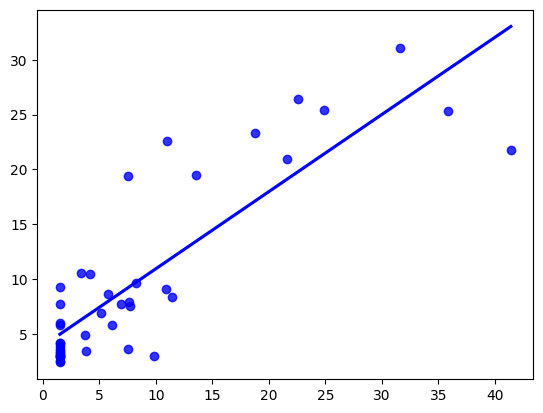

In [18]:
combi = ["Mean_Years_Of_Schooling_2020", "Net_FDI_2020", "Unemployment_2020", "Access_To_Electricity_2020"]

df_features, df_target = get_features_targets(df, combi, output_names)
n = len(df_features.columns)
df_features, df_target = remove_outliers(df_features, df_target)

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

target = prepare_target(df_target_test)
pred = predict(df_features_test, betas[str(combi)])

sns.regplot(x=target,y=pred,ci=None,color ='blue')